In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import util 
from skimage import morphology
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import regionprops
from scipy.ndimage import label
from google.colab.patches import cv2_imshow


from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

In [2]:
### add code here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Flowchart/

/content/drive/MyDrive/Flowchart


In [4]:
# Read image
img = cv2.imread('/content/drive/MyDrive/Flowchart/Input/straight_graph.jpeg')
height, width = img.shape[:2]
print("width: ", width)
print("height: ", height)

img = cv2.resize(img, (720,800))
height, width = img.shape[:2]
print("width: ", width)
print("height: ", height)


width:  1026
height:  1330
width:  720
height:  800


Graph image


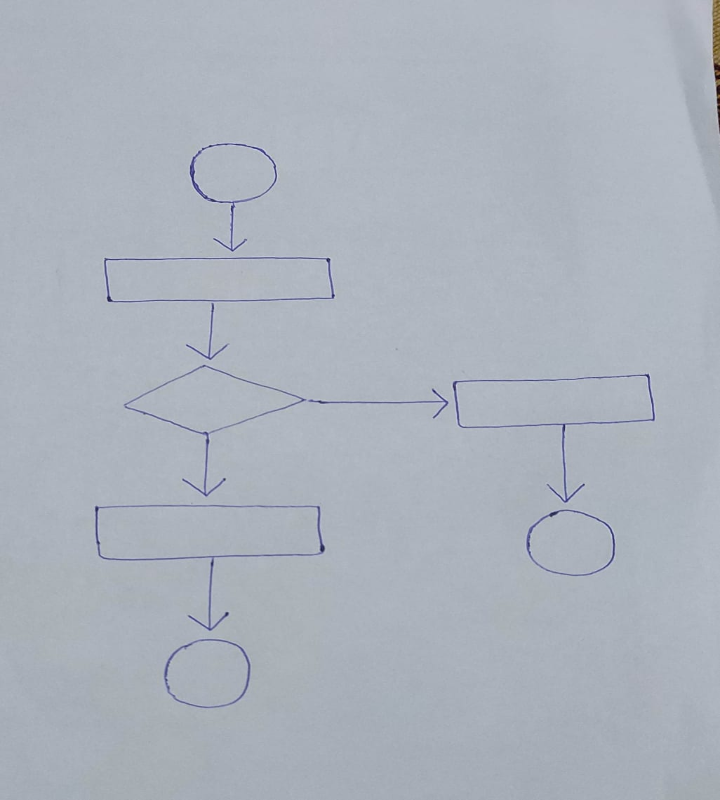

In [5]:
# Display Image
print("Graph image")
cv2_imshow(img)



Grayscale graph image


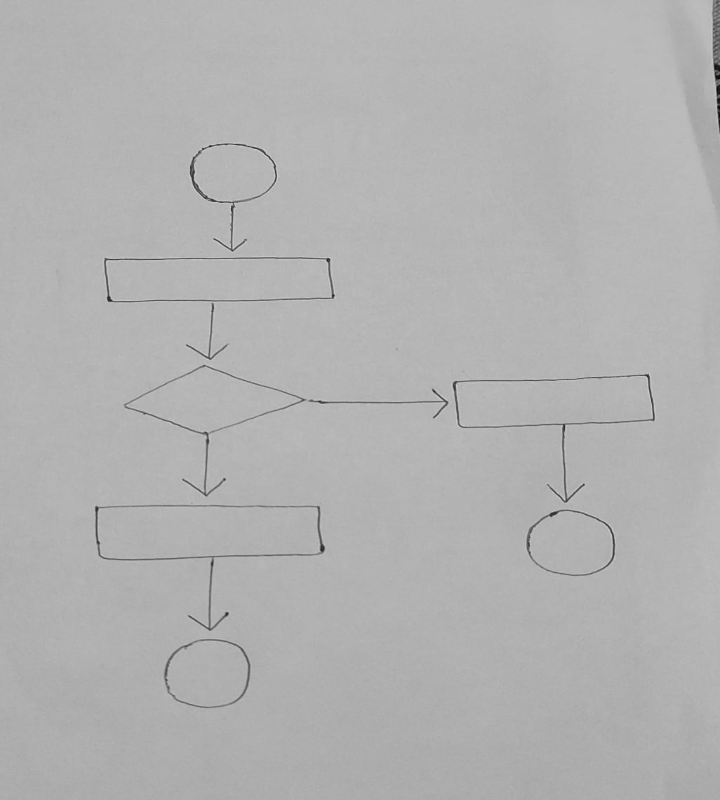

Contour on Graph image


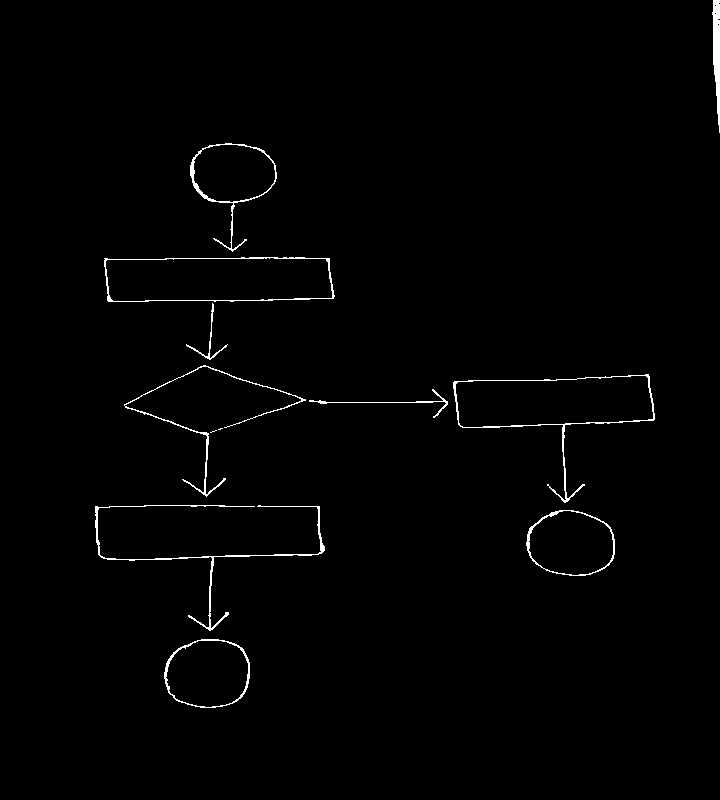

True

In [6]:

#convert into grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print('Grayscale graph image')
cv2_imshow(gray_img)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/Grayscale graph image.png', gray_img)

thresh, binary_image = cv2.threshold(gray_img.astype(np.uint8), 0, 255,
                                         cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print('Contour on Graph image')
cv2_imshow(binary_image)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/Contour on Graph image.png',binary_image)

In [7]:
# Apply Guassian blur to smooth the image
img_smooth = cv2.GaussianBlur(binary_image, (9, 9), sigmaX = 0, sigmaY = 0) 
img_smooth = cv2.fastNlMeansDenoising(img_smooth)

find_con_gray


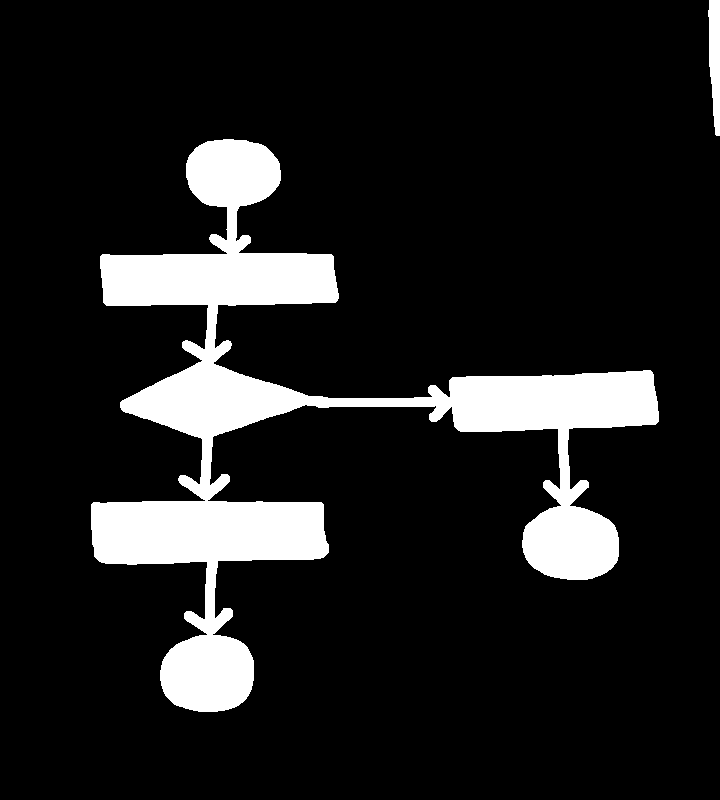

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


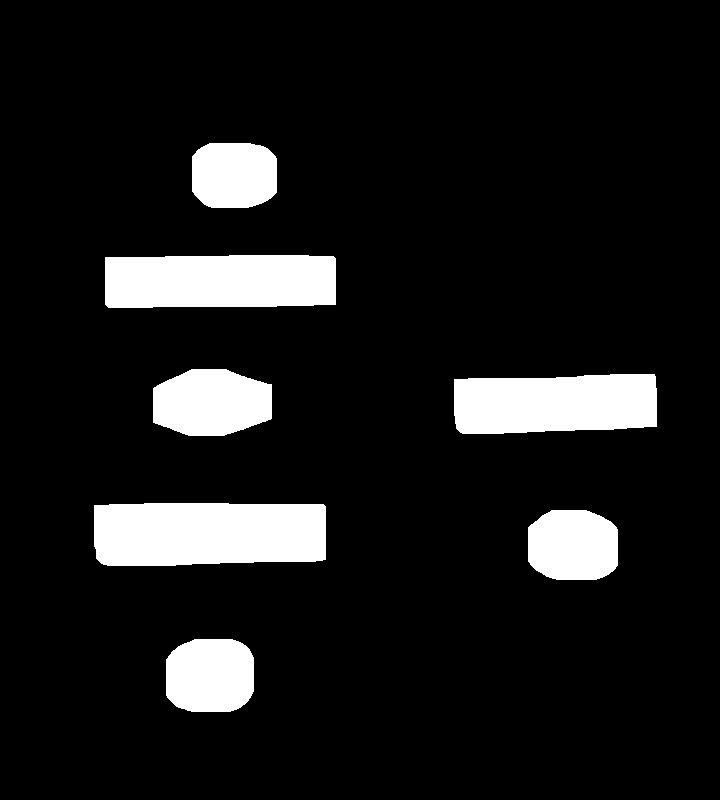

erosion_Binary_graph


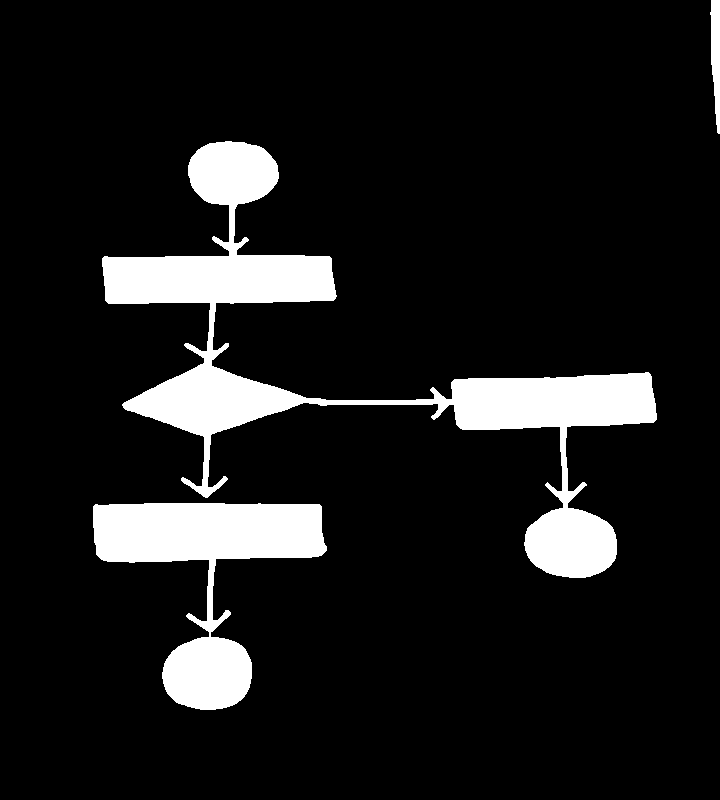

dilation_Binary_Cropped_graph


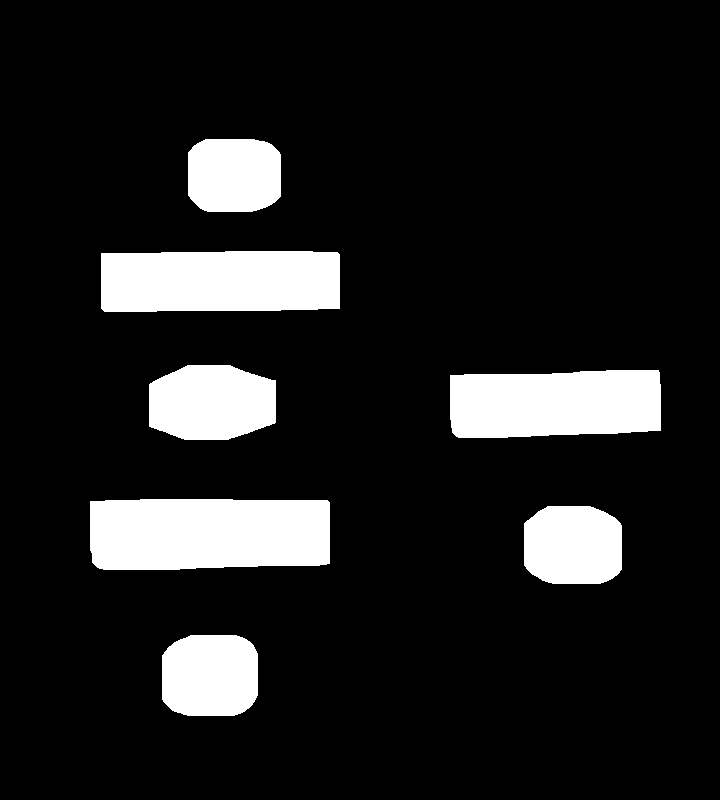

Only_Arrow_Binary_Cropped_graph


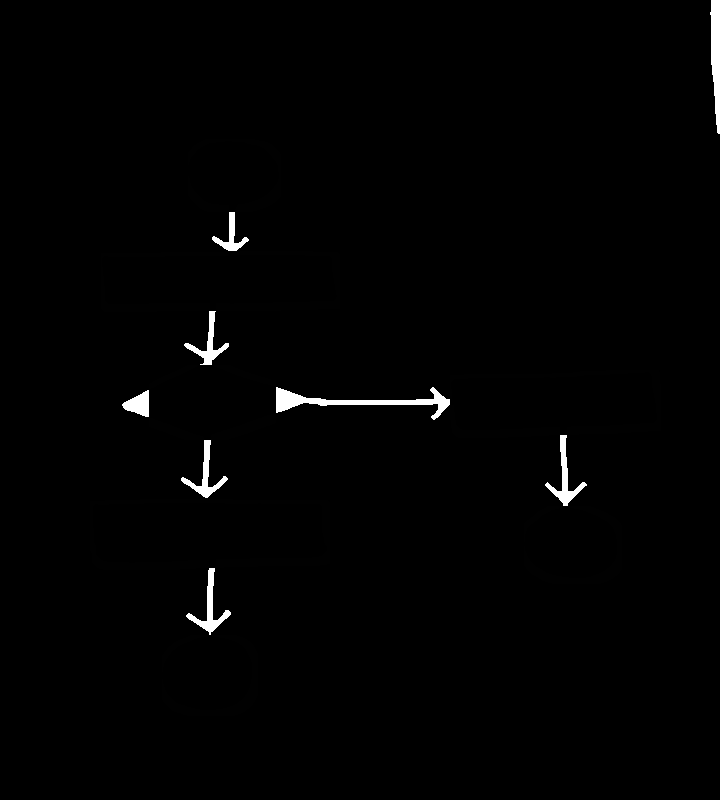

True

In [8]:
#fill shapes for identification
find_con_gray = img_smooth

cnts = cv2.findContours(find_con_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv2.drawContours(find_con_gray,[c], 0, (255,255,255), -1)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18,18))
opening = cv2.morphologyEx(find_con_gray, cv2.MORPH_OPEN, kernel, iterations=2)

print('find_con_gray')
cv2_imshow(find_con_gray)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/find_con_gray.png',find_con_gray)
print(opening)
cv2_imshow( opening)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/opening.png',opening)

#apply erosion on fill shapes
kernel = np.ones((3,3), np.uint8)
Fill_shape_erosion = cv2.erode(find_con_gray, kernel, iterations=2)
print('erosion_Binary_graph')
cv2_imshow( Fill_shape_erosion)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/erosion_Binary_graph.png',Fill_shape_erosion)



#apply dilation on shapes extracted from graph
kernel = np.ones((5,5), np.uint8)
Only_shape_dilate = cv2.dilate(opening, kernel, iterations=2)
print('dilation_Binary_Cropped_graph')
cv2_imshow(Only_shape_dilate)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/dilation_Binary_Cropped_graph.png',Only_shape_dilate)


#subtract fill graph from extracted shapes 
arrow =  Fill_shape_erosion - Only_shape_dilate 
print('Only_Arrow_Binary_Cropped_graph')
cv2_imshow( arrow)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/Only_Arrow_Binary_Cropped_graph.png',arrow)


Result


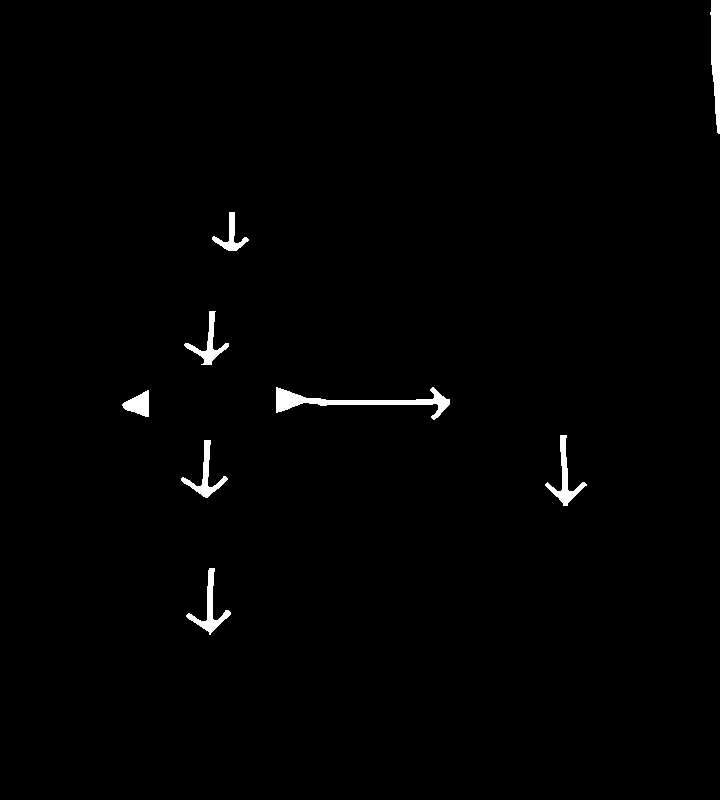

True

In [9]:
#smoothing on arrow image
blur_arrow = cv2.GaussianBlur(arrow,(3,3),0)
blur_arrow_result = cv2.threshold(blur_arrow, 100, 255, cv2.THRESH_BINARY)[1]
print("Result")
cv2_imshow( blur_arrow_result)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/blur_arrow_resulth.png',blur_arrow_result)


In [ ]:
#if we have noise then increase kernal size but at that time we don't have any noise so comment this section

#kernal = np.ones((7,7),np.uint8)
#close_arrows = cv2.morphologyEx( blur_arrow_result,cv2.MORPH_OPEN,kernel)

#cv2_imshow( close_arrows)



Edges of Dilation Inverted Binarize image


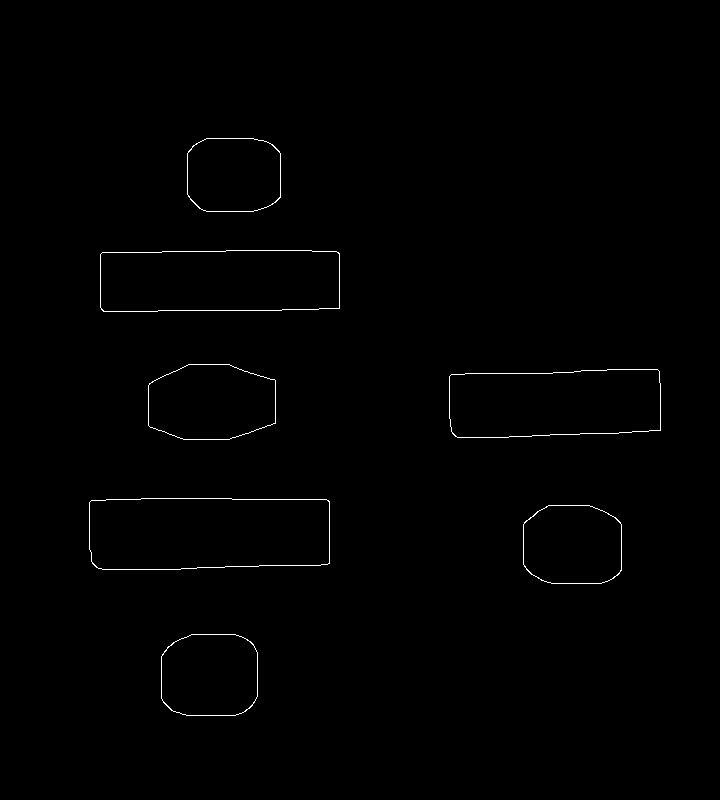

True

In [10]:
#canny edges detection
edges = cv2.Canny(image =Only_shape_dilate, threshold1 = 100, threshold2 = 100)
print('Edges of Dilation Inverted Binarize image')
cv2_imshow(edges)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/Edges of Dilation Inverted Binarize image.png',edges)

In [11]:

# Apply Hough transform to greyscale image


circles = cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT,1,25,
                            param1=20,param2=25,minRadius=35,maxRadius=60)

In [12]:
circle_img = np.zeros((img.shape[:2]), dtype = 'uint8')

In [13]:
# Draw the circles
if circles is not None:
    circles= np.uint16(np.around(circles))
    for i in circles[0, :]:
    # draw the outer circle
    # cv2.circle(image, center_coordinates, radius, color, thickness)
        cv2.circle(circle_img, (i[0], i[1]), i[2], (255), 2)

Circle detection Inverted Binarize image


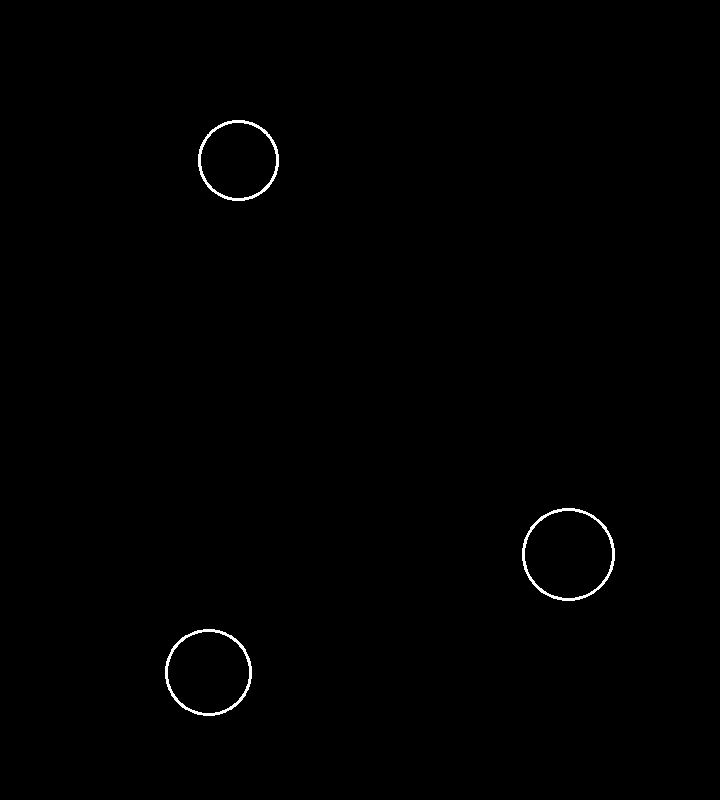

True

In [14]:
print('Circle detection Inverted Binarize image')
cv2_imshow(circle_img)
cv2.imwrite('/content/drive/MyDrive/Flowchart/Output/Circle detection Inverted Binarize image.png',circle_img)

In [16]:
from keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 200, 200

train_data_dir = '/content/drive/My Drive/Flowchart/shapes_dataset/train/'
validation_data_dir = '/content/drive/My Drive/Flowchart/shapes_dataset/valid/' 
test_data_dir = '/content/drive/My Drive/Flowchart/shapes_dataset/test/'



# normalize the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)

# automagically retrieve images and their classes for train and validation sets
batch_size = 32 

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode = 'grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode = 'grayscale',
        batch_size=batch_size,
        class_mode='categorical')

test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        color_mode = 'grayscale',
        #classes = ['test'],
        class_mode='categorical')

Found 2599 images belonging to 5 classes.
Found 449 images belonging to 5 classes.
Found 261 images belonging to 5 classes.


In [17]:


from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint


img_width, img_height = 200, 200
input_dim = 200*200
output_dim = 5

def CNN():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = (img_width, img_height, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(5, activation = 'softmax')) 
    return model

model = CNN()

In [18]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) # compile model


In [19]:
import os

# print model information
model.summary()

outputFolder = 'weights/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

filepath=outputFolder+"/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, \
                             save_best_only=False, save_weights_only=True, \
                             mode='auto', period=1)
callbacks_list = [checkpoint]

nb_epoch = 5


model_info = model.fit(
        train_generator,
        epochs=nb_epoch,
        batch_size=100,
        validation_data=validation_generator,
        validation_batch_size=100,
        callbacks=callbacks_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


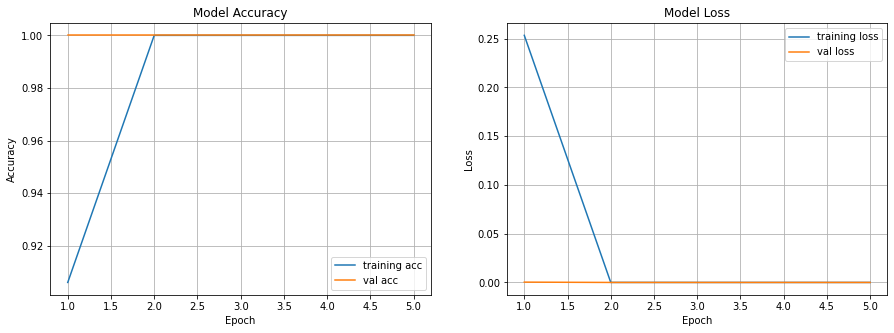

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # model history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['training acc', 'val acc'], loc='best')
    axs[0].grid(True)
    # model history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['training loss', 'val loss'], loc='best')
    axs[1].grid(True)
    plt.show()
plot_model_history(model_info)

In [21]:
_, training_accuracy = model.evaluate_generator(train_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print('training accuracy: %.2f' % (training_accuracy*100))

_, validation_accuracy = model.evaluate(validation_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print('validation accuracy: %.2f' % (validation_accuracy*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


training accuracy: 100.00
validation accuracy: 100.00


In [22]:
_, test_accuracy = model.evaluate_generator(test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [23]:
print('test accuracy: %.2f' % (test_accuracy*100))

test accuracy: 97.70


In [24]:
fname="/content/drive/My Drive/Flowchart/weight_cnn.hdf5"
model.save_weights(fname,overwrite=True)

In [25]:
fname="/content/drive/My Drive/Flowchart/weight_cnn.hdf5"
model.load_weights(fname)

Predicted :-  Rectangle


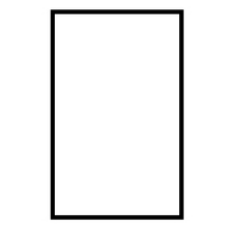

In [27]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

original_img = keras.preprocessing.image.load_img('/content/drive/My Drive/Flowchart/Input/rectangle_test.jpg', target_size=(200, 200, 1))
img = keras.preprocessing.image.load_img('/content/drive/My Drive/Flowchart/Input/rectangle_test.jpg', color_mode = 'grayscale', target_size=(200, 200, 1))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(np.array(img_array))
fig = plt.figure()
plt.imshow(original_img)
plt.axis("off")
output = { 0:'Circle',1:'Rectangle',2:'Square',3:'Star', 4:'Trianglr'} 
print("Predicted :- ",output[np.argmax(predictions[0])])
plt.show()

Predicted :-  Circle


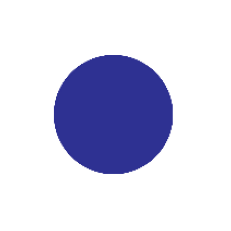

In [28]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

original_img = keras.preprocessing.image.load_img('/content/drive/My Drive/Flowchart/Input/circle.jpg', target_size=(200, 200, 1))
img = keras.preprocessing.image.load_img('/content/drive/My Drive/Flowchart/Input/circle.jpg', color_mode = 'grayscale', target_size=(200, 200, 1))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(np.array(img_array))
fig = plt.figure()
plt.imshow(original_img)
plt.axis("off")
output = { 0:'Circle',1:'Rectangle',2:'Square',3:'Star', 4:'Trianglr'} 
print("Predicted :- ",output[np.argmax(predictions[0])])
plt.show()

Predicted :-  Triangle


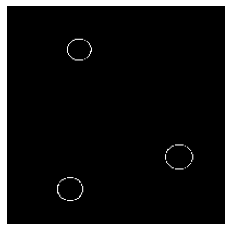

In [30]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

original_img = keras.preprocessing.image.load_img('/content/drive/My Drive/Flowchart/Output/Circle detection Inverted Binarize image.png', target_size=(200, 200, 1))
img = keras.preprocessing.image.load_img('/content/drive/My Drive/Flowchart/Output/Circle detection Inverted Binarize image.png', color_mode = 'grayscale', target_size=(200, 200, 1))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(np.array(img_array))
fig = plt.figure()
plt.imshow(original_img)
plt.axis("off")
output = { 0:'Circle',1:'Rectangle',2:'Square',3:'Star', 4:'Triangle'} 
print("Predicted :- ",output[np.argmax(predictions[0])])
plt.show()

In [29]:
import imutils
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tkinter as tk
import os
import shutil


In [ ]:
def detect( c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        area = cv2.contourArea(c)
        # compute the bounding box of the contour and use the
        # bounding box to compute the aspect ratio
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)#aspect ratio
        (z,v),(MA,ma),angle = cv2.fitEllipse(c)
        if ar*50 < 50:
            shape = "arrow"
        else:
    
            # if the shape is a triangle, it will have 3 vertices
            if len(approx) == 3:
                shape = "triangle"
    
            # if the shape has 4 vertices, it is either a square or
            # a rectangle
            elif len(approx) == 4:
                if (int(angle) >= 0 and int(angle) <=70 )or ar<=1.5:#Diamond 
                    shape = "Diamond"
                elif int(angle) > 70 and int(angle) <=85:#parallelogram
                    shape = "parallelogram"
                else :#normal square or rect       
                    # a square will have an aspect ratio that is approximately
                    # equal to one, otherwise, the shape is a rectangle
                    shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
    
            # if the shape is a pentagon, it will have 5 vertices
            elif len(approx) == 5:
                shape = "pentagon"
    
            # otherwise, we assume the shape is a circle or ellipse
            else:
                #if aspect ratio > 1 then ellipse
                if ar > 1.05 :
                    shape = "ellipse"
                else:
                    a = np.pi *( (w/2)**2)
                    shape = "circle"

        # return the name of the shape
        return shape

In [ ]:
img = cv2.imread('/content/drive/My Drive/Flowchart/Output/Circle detection Inverted Binarize image.png')
cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shape = detect(img)
print(shape)

error: ignored